In [1]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve, roc_curve
from itertools import combinations, product
import matplotlib
import csv

In [6]:
#ped_file = '../../DATA/ihart.ms2/ihart.ped'
#phase_dir = '../recomb_ihart.ms2'

ped_files = ['../../DATA/ssc.hg38/ssc.ped']
phase_dirs = ['../recomb_ssc.hg38']

#ped_files = ['../../DATA/ihart.ms2/ihart.ped',
#            '../../DATA/ssc.hg38/ssc.ped']
#phase_dirs = ['../recomb_ihart.ms2', '../recomb_ssc.hg38']

#ped_file = '../../DATA/spark/sparkfam.ped'
#phase_dir = '../recomb_spark'

colors=['#ef6c00', '#4db6ac', '#ce93d8ff']


In [7]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                if 'ssc' in ped_file:
                    child_id = child_id.replace('.', '_')
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex


print('ped loaded')
print('children', len(child_id_to_affected))




ped loaded
children 9371


In [8]:
deletions = []
for phase_dir in phase_dirs:
    with open('%s/deletions.json' % phase_dir) as f:
        deletions.extend(json.load(f))

# filter deletions
deletions = [d for d in deletions if d['length']>=1000]
print('remaining deletions', len(deletions))

deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))
    
deletions = [d for d in deletions if not d['is_hts']]
print('remaining deletions', len(deletions))

remaining deletions 308269
remaining deletions 308269
remaining deletions 187225


In [9]:
child_to_deletions = defaultdict(int)

for d in deletions:
    for child in d['trans']:
        child_to_deletions[(d['family'], child)] += d['length']

In [10]:
children = sorted(set([child for fam, child in child_to_deletions.keys()]))
child_to_index = dict([(x, i) for i, x in enumerate(children)])
is_aff = np.array([child_id_to_affected[child]=='2' for child in children])
is_ssc = np.array(['SSC' in child for child in children])

child_deletions = np.zeros((len(children),))
child_to_fam = dict()
for (fam, child), d in child_to_deletions.items():
    index = child_to_index[child]
    if child_deletions[index] == 0:
        child_deletions[index] = d
        child_to_fam[child] = fam

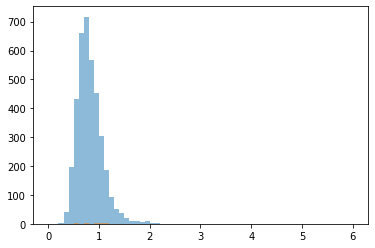

In [11]:
plt.hist(np.clip(child_deletions[is_ssc]/1000000, 0, 6), alpha=0.5, bins=np.arange(0, 6.1, 0.1))
plt.hist(np.clip(child_deletions[~is_ssc]/1000000, 0, 6), alpha=0.5, bins=np.arange(0, 6.1, 0.1))

plt.show()

In [12]:
child_phen = np.zeros((len(children), 4))
child_to_index.update([(fam + ('.p1' if is_aff[i] else '.s1'), i) for i, child in enumerate(children)])

#with open('../phenotypes/ssc/designated.unaffected.sibling.data/ssc_commonly_used.csv', 'r') as f:
with open('../phenotypes/ssc/designated.unaffected.sibling.data/vineland_ii.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    # 'vabs_ii_communication', 'vabs_ii_dls_standard', 'vabs_ii_motor_skills', 'vabs_ii_soc_standard'
    phen_indices = [header.index('communication_standard'), header.index('dls_standard'), header.index('soc_standard'), header.index('motor_skills_standard')]
    for pieces in reader:
        if pieces[0] in child_to_index:
            child_phen[child_to_index[pieces[0]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]
            
        
with open('../phenotypes/ssc/proband.data/vineland_ii.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    # 'vabs_ii_communication', 'vabs_ii_dls_standard', 'vabs_ii_motor_skills', 'vabs_ii_soc_standard'
    phen_indices = [header.index('communication_standard'), header.index('dls_standard'), header.index('soc_standard'), header.index('motor_skills_standard')]
    for pieces in reader:
        if pieces[0] in child_to_index:
            child_phen[child_to_index[pieces[0]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]
            
    
print(np.sum(child_phen[is_ssc]!=0, axis=0)/np.sum(is_ssc))


['individual', 'measure', 'communication_standard', 'communication_sum', 'community_age_equiv', 'community_raw_score', 'community_v_score', 'composite_standard_score', 'coping_age_equiv', 'coping_raw_score', 'coping_v_score', 'dls_standard', 'dls_sum', 'domestic_age_equiv', 'domestic_raw_score', 'domestic_v_score', 'express_age_equiv', 'expressive_raw_score', 'express_v_score', 'fine_age_equiv', 'fine_raw_score', 'fine_v_score', 'gross_age_equiv', 'gross_raw_score', 'gross_v_score', 'ir_age_equiv', 'ir_raw_score', 'ir_v_score', 'maladaptive_ex_raw_score_index', 'maladaptive_ex_v_score', 'maladaptive_int_raw_score_index', 'maladaptive_int_v_score', 'motor_skills_standard', 'motor_skills_sum', 'personal_age_equiv', 'personal_raw_score', 'personal_v_score', 'plt_age_equiv', 'plt_raw_score', 'plt_v_score', 'receptive_age_equiv', 'receptive_raw_score', 'receptive_v_score', 'soc_standard', 'soc_sum', 'sum_standard', 'written_age_equiv', 'written_raw_score', 'written_v_score']
['individual', 

In [13]:
with open('../phenotypes/ihart/Vineland/VINE1.csv', 'r', encoding = "ISO-8859-1") as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    # 'vabs_ii_communication', 'vabs_ii_dls_standard', 'vabs_ii_motor_skills', 'vabs_ii_soc_standard'
    phen_indices = [header.index('Comm_Standard_Score'), header.index('DLS_Standard_Score'), header.index('Soc_Standard_Score'), header.index('Motor_Skills_Standard_Score')]
    for pieces in reader:
        if pieces[6] in child_to_index:
            child_phen[child_to_index[pieces[6]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]
            
print(np.sum(child_phen[~is_ssc]!=0, axis=0)/np.sum(~is_ssc))


['FormID', 'Version', 'PatientNum', 'ProjectNum', 'ProjectName', 'Gender', 'Individual ID', 'data_entry_date', 'original_source_name', ' original_source_id', 'AU/Family ID', 'NDAR_GUID', 'Status', 'InterviewMonth', 'InterviewDay', 'InterviewYear', 'age', 'Interviewernum', 'Interviewer_Org', 'Validated', 'Receptive_Raw_Score_Vine2', 'Receptive_v_Scale_Score', 'Receptive_90_CI', 'Receptive_Adaptive_Level', 'Receptive_Age_Equiv_Year_EQ_LT_GT', 'Receptive_Age_Equiv_Year', 'Receptive_Age_Equivalent_Month', 'Receptive_Age_Equivalent_Cmb', 'Receptive_Score_Minus_Median', 'Receptive_S_W', 'Expressive_Raw_Score_Vine2', 'Expressive_v_Scale_Score', 'Expressive_90_CI', 'Expressive_Adaptive_Level', 'Expressive_Age_Equiv_Year_EQ_LT_GT', 'Expressive_Age_Equiv_Year', 'Expressive_Age_Equivalent_Mont', 'Expressive_Age_Equivalent_cmb', 'Expressive_Score_Minus_Median', 'Expressive_S_W', 'Written_Raw_Score_Vine2', 'Written_v_Scale_Score', 'Written_90_CI', 'Written_Adaptive_Level', 'Written_Age_Equiv_Year_E

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)


ValueError: x and y must have length at least 2.

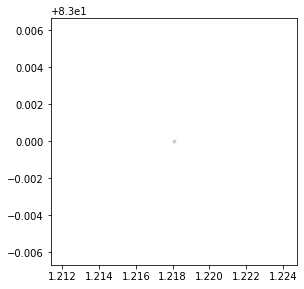

In [14]:
fig=plt.figure(figsize=(15, 10))

titles = ['Communication', 'Daily Living Skills', 'Social']
#titles = ['Aware', 'Cog', 'Comm', 'Motiv', 'Manner']

ax = plt.subplot(2, 3, 1)
for i in range(3):
    plt.subplot(2, 3, i+1, sharex=ax, sharey=ax)

    indices = (child_phen[:, i]!=0) & is_aff & is_ssc
    plt.scatter(child_deletions[indices]/1000000,
                child_phen[indices, i],
                marker='.', alpha=0.5, color=colors[2])
    l = sm.nonparametric.lowess(child_phen[indices, i], 
                                child_deletions[indices]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='total (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(child_deletions[indices]/1000000, 
                                                                                                   child_phen[indices, i]),
            color=colors[2])
    
    indices = (child_phen[:, i]!=0) & ~is_aff & is_ssc
    plt.scatter(child_deletions[indices]/1000000,
                child_phen[indices, i],
                marker='.', alpha=0.5, color=colors[1])
    l = sm.nonparametric.lowess(child_phen[indices, i], 
                                child_deletions[indices], return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='total (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(child_deletions[indices]/1000000, 
                                                                                                   child_phen[indices, i]),
            color=colors[1])
    plt.title(titles[i])
    plt.legend()
    #plt.axhline(100, color='black', linestyle='--')
    #plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
    #plt.ylabel('Vineland II subscore\nof neurotypical child')
        
        
    plt.subplot(2, 3, i+4, sharex=ax, sharey=ax)

    indices = (child_phen[:, i]!=0) & is_aff & ~is_ssc
    plt.scatter(child_deletions[indices]/1000000,
                child_phen[indices, i],
                marker='.', alpha=0.5, color=colors[2])
    l = sm.nonparametric.lowess(child_phen[indices, i], 
                                child_deletions[indices]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='total (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(child_deletions[indices]/1000000, 
                                                                                                   child_phen[indices, i]),
            color=colors[2])
    
    indices = (child_phen[:, i]!=0) & ~is_aff & ~is_ssc
    plt.scatter(child_deletions[indices]/1000000,
                child_phen[indices, i],
                marker='.', alpha=0.5, color=colors[1])
    l = sm.nonparametric.lowess(child_phen[indices, i], 
                                child_deletions[indices]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='total (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(child_deletions[indices]/1000000, 
                                                                                                   child_phen[indices, i]),
            color=colors[1])
    plt.title(titles[i])
    plt.legend()
    #plt.axhline(100, color='black', linestyle='--')
    #plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
    #plt.ylabel('Vineland II subscore\nof neurotypical child')
        

plt.tight_layout()
plt.savefig('../plots/subclinical.png', dpi=fig.dpi, bbox_inches='tight')

#plt.show()

In [15]:
intervals = np.arange(0, 2.0, 0.05)
num_bootstraps = 100
bootstraps = np.zeros((len(intervals), 3, 3, num_bootstraps))
# bootstrap conf intervals

for i in range(3):
    print(i)
    indices = (nt_phen[:, i]!=0) & (aut_phen[:, i]!=0) & ~is_outlier
    
    for j in range(num_bootstraps):
        boot_ind = np.random.choice(np.where(indices)[0], size=len(indices), replace=True)
        #bootstraps[:, i, 0, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], deletions_match[boot_ind, 0]/1000000, xvals=intervals)
        #bootstraps[:, i, 1, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], deletions_match[boot_ind, 1]/1000000, xvals=intervals)
        #bootstraps[:, i, 2, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], np.sum(deletions_match[boot_ind, :], axis=1)/1000000, xvals=intervals)
        
        bootstraps[:, i, 0, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], deletions_match[boot_ind, 0]/1000000, xvals=intervals)
        bootstraps[:, i, 1, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], deletions_match[boot_ind, 1]/1000000, xvals=intervals)
        bootstraps[:, i, 2, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], np.sum(deletions_match[boot_ind, :], axis=1)/1000000, xvals=intervals)
        
        
        

0


NameError: name 'nt_phen' is not defined

NameError: name 'nt_phen' is not defined

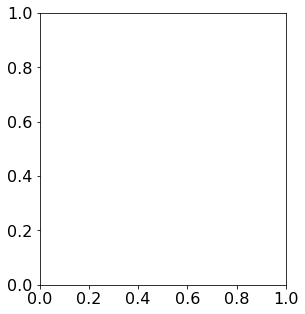

In [16]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

fig=plt.figure(figsize=(15, 5))

titles = ['Communication', 'Daily Living Skills', 'Social']
i = 1

ax = plt.subplot(1, 3, 1)

plt.subplot(1, 3, 1, sharex=ax, sharey=ax)
indices = (nt_phen[:, i]!=0) & ~is_outlier
plt.scatter(deletions_match[indices, 1]/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
        
l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 1]/1000000, return_sorted=True)
end_index = np.searchsorted(intervals, l[-1, 0])+1
plt.plot(l[:, 0], l[:, 1], linewidth=3,
                color=colors[1])
plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 1, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 1, :], 0.05, axis=1), alpha=0.25, color=colors[1])
    
#plt.legend()
#plt.axhline(100, color='black', linestyle='--')
plt.text(0, 70, 'r:%0.2f; pvalue: %0.3f' % stats.pearsonr(deletions_match[indices, 1]/1000000, nt_phen[indices, i]))
plt.title('Paternal') 
plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
plt.ylabel('Daily living skills subscore\nof neurotypical child')
    

plt.subplot(1, 3, 2, sharex=ax, sharey=ax)

plt.scatter(deletions_match[indices, 0]/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
    
    
l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 0]/1000000, return_sorted=True)
end_index = np.searchsorted(intervals, l[-1, 0])+1
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(deletions_match[indices, 0]/1000000, nt_phen[indices, i]),
            color=colors[1])
plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 0, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 0, :], 0.05, axis=1), alpha=0.25, color=colors[1])
    
plt.text(0, 70, 'r: %0.2f; pvalue: %0.3f' % stats.pearsonr(deletions_match[indices, 0]/1000000, nt_phen[indices, i]))
plt.title('Maternal') 
#plt.legend()
#plt.axhline(100, color='black', linestyle='--')
plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
#plt.ylabel('Vineland II subscore\nof neurotypical child')
    
plt.subplot(1, 3, 3, sharex=ax, sharey=ax)
plt.scatter(np.sum(deletions_match[indices, :], axis=1)/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
l = sm.nonparametric.lowess(nt_phen[indices, i], np.sum(deletions_match[indices, :], axis=1)/1000000, return_sorted=True)
end_index = np.searchsorted(intervals, l[-1, 0])+1
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='total (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(np.sum(deletions_match[indices, :], axis=1)/1000000, nt_phen[indices, i]),
            color=colors[1])
plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 2, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 2, :], 0.05, axis=1), alpha=0.25, color=colors[1])
    
    
plt.text(0, 70, 'r: %0.2f; pvalue: %0.3f' % stats.pearsonr(np.sum(deletions_match[indices, :], axis=1)/1000000, nt_phen[indices, i]))
#plt.legend()
#plt.axhline(100, color='black', linestyle='--')
plt.title('Total')
plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
#plt.ylabel('Vineland II subscore\nof neurotypical child')
        

#plt.tight_layout()
plt.savefig('../plots/subclinical.png', dpi=fig.dpi, bbox_inches='tight')

#plt.show()

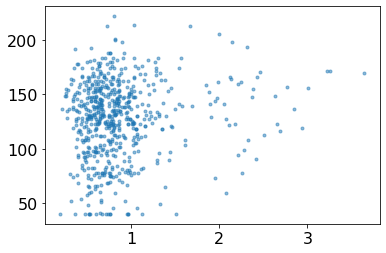

In [102]:
i = 1
indices = (nt_phen[:, i]!=0) & (aut_phen[:, i]!=0) & ~is_outlier

plt.scatter(np.sum(deletions_match[indices, :], axis=1)/1000000, aut_phen[indices, i]+nt_phen[indices, i],
           marker='.', alpha=0.5)
plt.show()

In [101]:
i = 1
indices = (nt_phen[:, i]!=0) & (aut_phen[:, i]!=0) & ~is_outlier
X = np.hstack((sim[indices, :], deletions_match[indices, :]/1000000, np.ones((np.sum(indices), 1))))
y = aut_phen[indices, i]+nt_phen[indices, i]

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.640
Date:                Tue, 07 Dec 2021   Prob (F-statistic):             0.0329
Time:                        15:36:41   Log-Likelihood:                -3175.1
No. Observations:                 637   AIC:                             6360.
Df Residuals:                     632   BIC:                             6382.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             8.1294     30.427      0.267      0.7

In [114]:
i = 1
indices = (nt_phen[:, i]!=0) & (aut_phen[:, i]!=0) & ~is_outlier
X = np.hstack((np.vstack((sim[indices, :], sim[indices, :])), 
                np.vstack((deletions_child[indices, :, 0], deletions_child[indices, :, 1])), 
                np.vstack((deletions_match[indices, :]/1000000, deletions_match[indices, :]/1000000)),
                np.ones((2*np.sum(indices), 1))))
y = np.hstack((aut_phen[indices, i], nt_phen[indices, i]))

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.688
Date:                Tue, 07 Dec 2021   Prob (F-statistic):             0.0135
Time:                        15:49:12   Log-Likelihood:                -5668.5
No. Observations:                1274   AIC:                         1.135e+04
Df Residuals:                    1267   BIC:                         1.139e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9430     12.689      0.232      0.8

In [122]:
i = 1
indices = (nt_phen[:, i]!=0) & (aut_phen[:, i]!=0) & ~is_outlier
X = np.hstack((#np.vstack((sim[indices, :], sim[indices, :])), 
                np.vstack((np.sum(deletions_child[indices, :, 0], axis=1)[:, np.newaxis]/1000000, 
                           np.sum(deletions_child[indices, :, 1], axis=1)[:, np.newaxis]/1000000)), 
                #np.vstack((deletions_match[indices, :]/1000000, deletions_match[indices, :]/1000000)),
                np.ones((2*np.sum(indices), 1))))
y = np.hstack((aut_phen[indices, i], nt_phen[indices, i]))

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.835
Date:                Tue, 07 Dec 2021   Prob (F-statistic):             0.0158
Time:                        15:53:29   Log-Likelihood:                -5673.6
No. Observations:                1274   AIC:                         1.135e+04
Df Residuals:                    1272   BIC:                         1.136e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3628      0.978      2.416      0.0

In [267]:
print(sibpairs[0])

('AU0012.AU001203.AU001204', ('AU001203', 'AU001204'))


In [1]:
i = 1
indices = (child_phen[:, i]!=0) & ~is_ssc
X = np.hstack((#sim[indices, :], 
                #np.sum(deletions_child[indices, :, 0]-deletions_match[indices, :], axis=1)[:, np.newaxis]/1000000,
                #np.sum(deletions_child[indices, :, 1]-deletions_match[indices, :], axis=1)[:, np.newaxis]/1000000,
                np.sum(child_deletions[indices, :], axis=1)[:, np.newaxis]/1000000,
                is_aut[indices, np.newaxis],
                np.ones((np.sum(indices), 1))))
y = child_phen[indices, i]

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

NameError: name 'child_phen' is not defined

In [13]:
plt.hist(np.sum(child_deletions[is_ssc], axis=1)[:, np.newaxis]/1000000, bins=np.arange(0, 8, 0.1), alpha=0.5)
plt.hist(np.sum(child_deletions[~is_ssc], axis=1)[:, np.newaxis]/1000000, bins=np.arange(0, 8, 0.1), alpha=0.5)
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

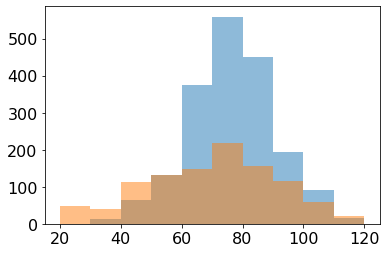

In [645]:
plt.hist(child_phen[is_ssc & is_aut & (child_phen[:, i] != 0), i], alpha=0.5, bins=np.arange(20, 130, 10))
plt.hist(child_phen[~is_ssc & is_aut & (child_phen[:, i] != 0), i], alpha=0.5, bins=np.arange(20, 130, 10))
plt.show()

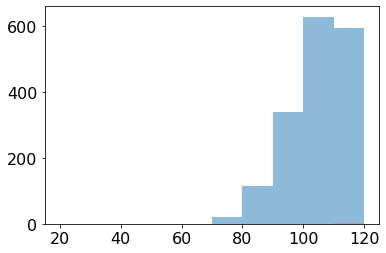

In [646]:
plt.hist(child_phen[is_ssc & ~is_aut & (child_phen[:, i] != 0), i], alpha=0.5, bins=np.arange(20, 130, 10))
plt.hist(child_phen[~is_ssc & ~is_aut & (child_phen[:, i] != 0), i], alpha=0.5, bins=np.arange(20, 130, 10))
plt.show()